## 46-775 Advanced Risk Management
### Assignment 2
<table>
<thead>
  <tr>
    <th>Team Members</th>
    <th>Andrew ID</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Hung Pham Khac</td>
    <td>khpham</td>
  </tr>
  <tr>
    <td>Chen Junjia</td>
    <td>junjiac</td>
  </tr>
  <tr>
    <td>Hu Runze</td>
    <td>runzehu</td>
  </tr>
  <tr>
    <td>Chia-Wei Lai</td>
    <td>clai2</td>
  </tr>
</tbody>
</table>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as sm
from pykalman import KalmanFilter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Part 1

In [2]:
def stationarity(a, cutoff = 0.05):
  if adfuller(a)[1] < cutoff:
    print("The series is stationary")
    print(adfuller(a))
    print("p-value = ", adfuller(a)[1])
  else:
    print("The series is NOT stationary at the 5% level of significance")
    print(adfuller(a))
    print("p-value = ", adfuller(a)[1])

In [3]:
startDate = datetime(2014, 4, 30)
endDate = datetime(2024, 4, 30)
symbol_list = ['EPI','EWY']
data = yf.download(symbol_list, start=startDate, end=endDate)['Adj Close']

# create a Pandas dataframe 
stationarity(data['EPI'])
stationarity(data['EWY'])

[*********************100%%**********************]  2 of 2 completed


The series is NOT stationary at the 5% level of significance
(0.5740282670718917, 0.986957665472608, 14, 2502, {'1%': -3.4329663156361883, '5%': -2.8626958747571405, '10%': -2.5673853168272736}, 1183.0250529182476)
p-value =  0.986957665472608
The series is NOT stationary at the 5% level of significance
(-1.8799633271726985, 0.34154489903023544, 7, 2509, {'1%': -3.432959008741782, '5%': -2.862692648021296, '10%': -2.567383598871881}, 6277.51235965303)
p-value =  0.34154489903023544


In [4]:
model = sm.ols(formula="EPI ~ EWY", data=data).fit()
residuals = data.loc[:, "EPI"] - (model.params[0] + model.params[1] * data.loc[:, "EWY"])
stationarity(residuals)

The series is NOT stationary at the 5% level of significance
(0.5278372934844108, 0.9856950754462054, 1, 2515, {'1%': -3.4329527780962255, '5%': -2.8626898965523724, '10%': -2.567382133955709}, 946.829125172786)
p-value =  0.9856950754462054


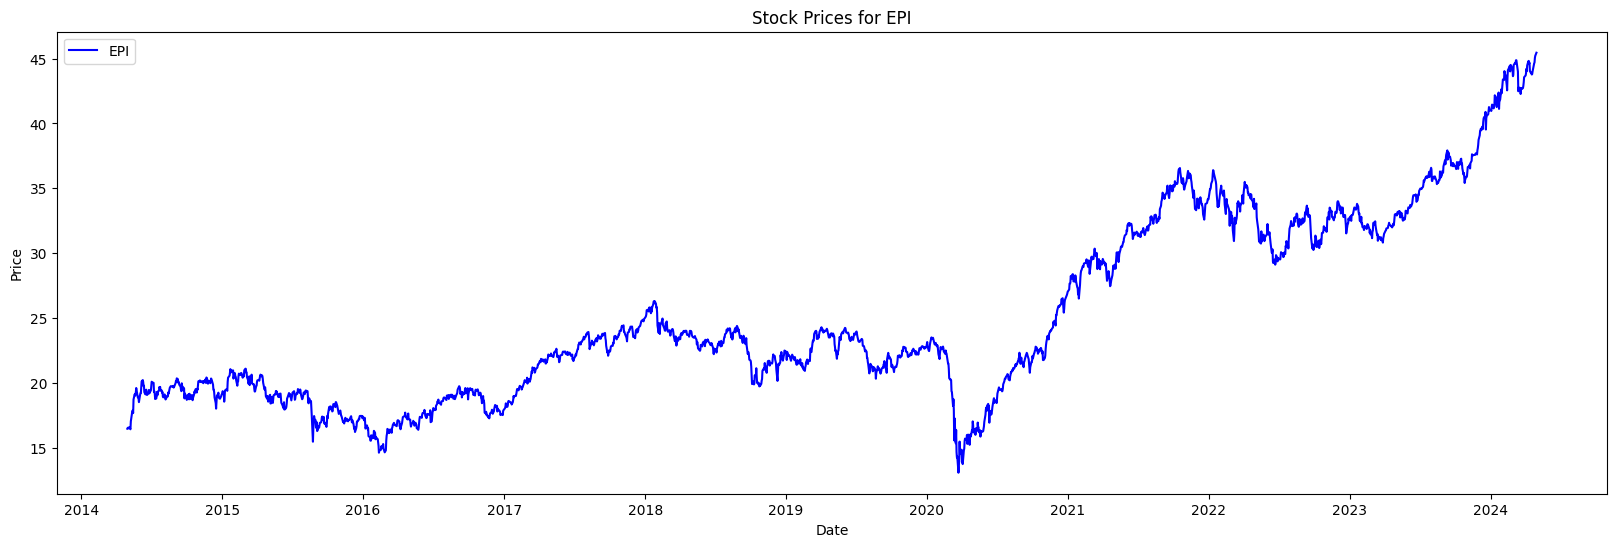

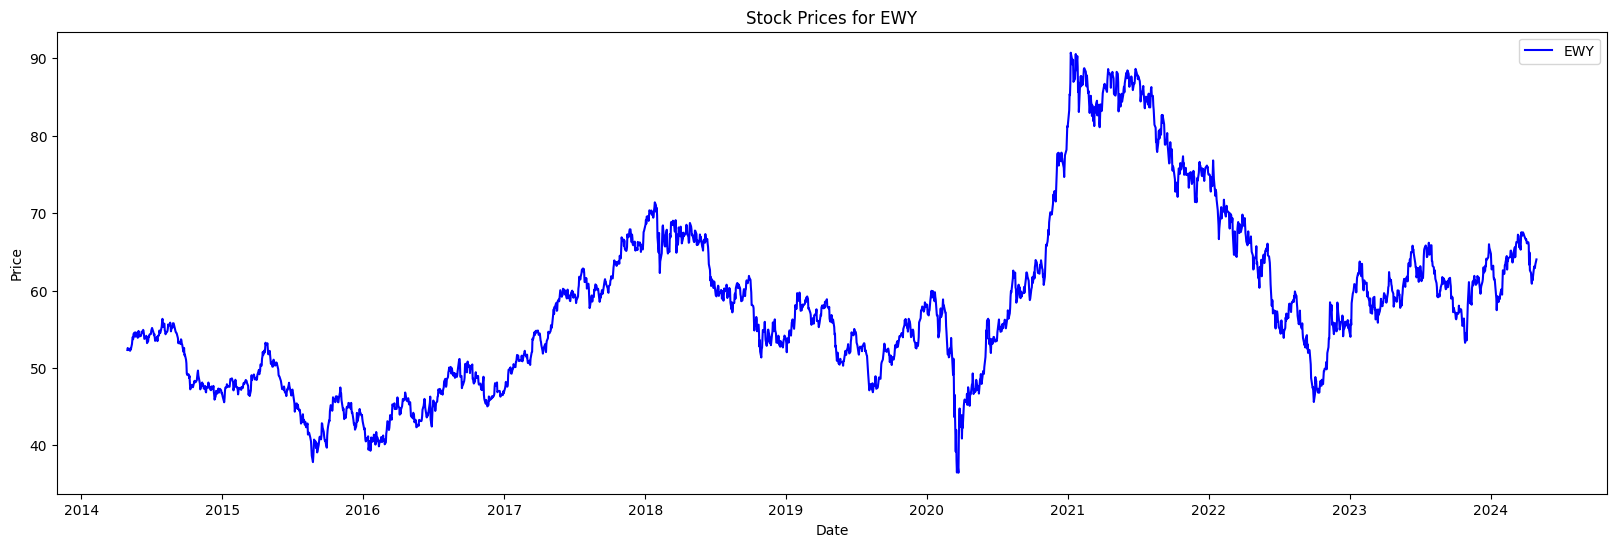

The series is stationary
(-3.539738087048903, 0.007023295683785552, 17, 2499, {'1%': -3.4329694597063978, '5%': -2.8626972631809684, '10%': -2.567386056042265}, 4157.483571941473)
p-value =  0.007023295683785552


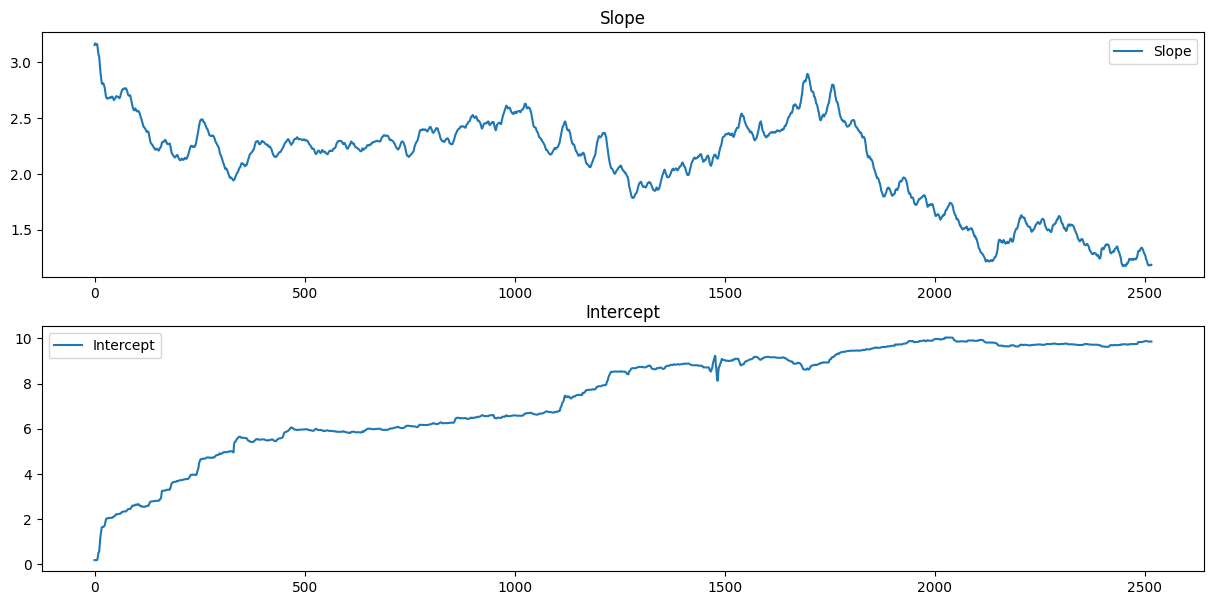

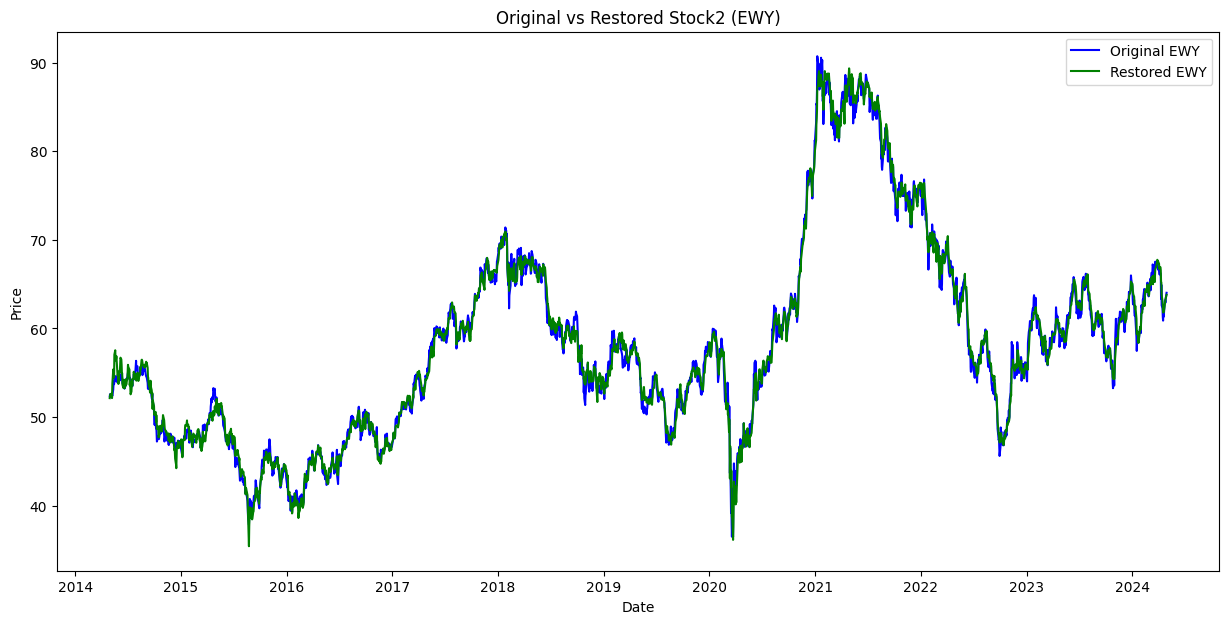

Mean Slope: 2.106524065685945
Mean Intercept: 7.483419302900992


In [5]:
data1 = data.copy()
Stock1 = data1['EPI'].values.reshape(-1, 1)
Stock2 = data1['EWY'].values.reshape(-1, 1)

# Plot stock prices
plt.figure(figsize=(20, 6))
plt.plot(data1.index, data1['EPI'], label='EPI', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices for EPI')
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(data1.index, data1['EWY'], label='EWY', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices for EWY')
plt.legend()
plt.show()

# Prepare data for Kalman Filter
H = np.insert(Stock1, Stock1.shape[1], 1, axis=1)
H = H.reshape(len(Stock1), 1, 2)
F = np.eye(2)
Q = [[1e-4, 0], [0, 1e-4]]
R = 1
X0 = [0, 0]
P0 = [[1, 0], [0, 1]]

# Initialize Kalman Filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  transition_matrices=F,
                  observation_matrices=H,
                  transition_covariance=Q,
                  observation_covariance=R,
                  initial_state_mean=X0,
                  initial_state_covariance=P0)

# Filtering
state_means, state_covs = kf.filter(Stock2)

# Extract beta (slope) and intercept from state_means
beta = state_means[:, 0]
intc = state_means[:, 1]

# Reshape beta and intercept arrays
beta = beta.reshape(len(beta), 1)
intc = intc.reshape(len(intc), 1)

# Restore EWY based on EPI and estimated parameters
Stock2_restored = (Stock1 * beta + intc)
data1['portfolio'] = Stock2 - Stock1 * beta
data1['beta'] = beta
stationarity(data1['portfolio'])

# check residuals
data1['residuals'] = Stock2 - Stock2_restored

# Plot slope and intercept
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(beta, label="Slope")
plt.title('Slope')
plt.legend()

plt.subplot(212)
plt.plot(intc, label="Intercept")
plt.title('Intercept')
plt.legend()
plt.show()

# Plot restored EWC
plt.figure(figsize=(15, 7))
plt.plot(data1.index, Stock2, label="Original EWY", color='blue')
plt.plot(data1.index, Stock2_restored, label="Restored EWY", color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Original vs Restored Stock2 (EWY)')
plt.legend()
plt.show()

# Print mean slope and intercept
print("Mean Slope:", np.mean(state_means[:, 0]))
print("Mean Intercept:", np.mean(state_means[:, 1]))

Residual analysis:
The series is stationary
(-17.807731092065296, 3.19860766190935e-30, 0, 2516, {'1%': -3.4329517425474014, '5%': -2.862689439250822, '10%': -2.5673818904827863}, 4019.5872281024)
p-value =  3.19860766190935e-30


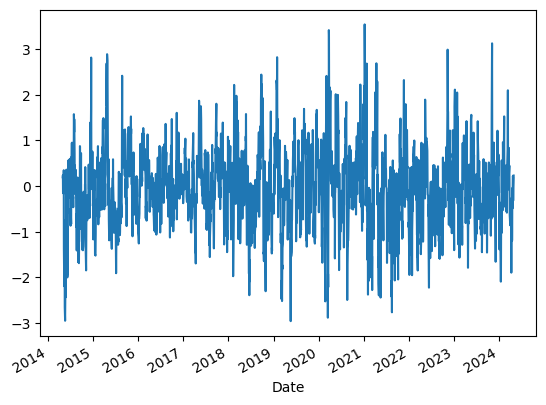

In [6]:
# Apply an Augmented Dickey-Fuller (ADF) test to the residuals from your Kalman Filter analysis
print('Residual analysis:')
data1['residuals'].plot()
stationarity(data1['residuals'])

Portfolio analysis:
The series is stationary
(-3.539738087048903, 0.007023295683785552, 17, 2499, {'1%': -3.4329694597063978, '5%': -2.8626972631809684, '10%': -2.567386056042265}, 4157.483571941473)
p-value =  0.007023295683785552


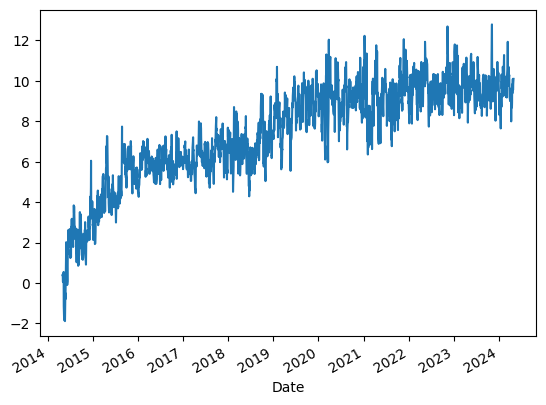

In [7]:
print('Portfolio analysis:')
data1['portfolio'].plot()
stationarity(data1['portfolio'])

### Strategy

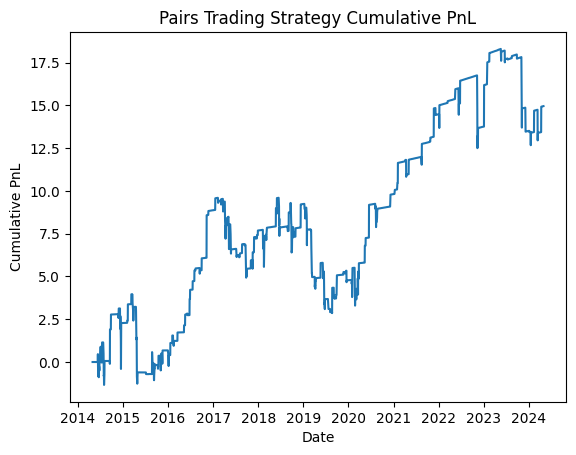

Part 1 back-testing result: {'Cumulative PnL': 14.958483263690736, 'Maximum Drawdown': -6.744012239059586, 'Sharpe Ratio': 0.36723605928110165, 'Profitability': 0.8966626457579413}


In [8]:
# Define strategy function by using RSI (long 1 unit when RSI < 50 and short 1 unit when RSI > 50)
def sign(data, period=30, buy=45, sell=55):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return (rsi < buy) * 1 + (rsi > sell) * -1

# Define the back testing function
def back_testing(validation_data, r=0.05):
    validation_data['Sign'] = sign(validation_data['portfolio'])
    validation_data.dropna(inplace=True)
    validation_data['PnL'] = 0.0
    number1 = 0
    number2 = 0
    account = 0
    old_price1 = 0
    old_price2 = 0
    for index, row in validation_data.iterrows():
        account *= np.exp(r * 1 / 252)
        pnl = number1 * (row['Stock1'] - old_price1) + number2 * (row['Stock2'] - old_price2) + (account - account * np.exp(- r * 1 / 252))
        validation_data.loc[index, 'PnL'] = pnl
        old_price1 = row['Stock1']
        old_price2 = row['Stock2']
        account -= row['Stock2'] * (row['Sign'] - number2) + row['Stock1'] * (row['Sign'] * (-row['beta']) - number1)
        number1 = row['Sign'] * (-row['beta'])
        number2 = row['Sign']
    validation_data['Cum PnL'] = validation_data['PnL'].cumsum()
    # Calculate the maximum drawdown
    max_drawdown = (validation_data['Cum PnL'] - validation_data['Cum PnL'].cummax()).min()
    # Calculate the Sharpe Ratio
    sharpe_ratio = validation_data['PnL'].mean() * 252 / (validation_data['PnL'].std() * np.sqrt(252))
    # Calculate the profitability
    profitability = (validation_data['PnL'] > 0).sum() / ((validation_data['PnL'] > 0).sum() + (validation_data['PnL'] < 0).sum())
    # Plot the profit trend
    plt.plot(validation_data['Cum PnL'])
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.title('Pairs Trading Strategy Cumulative PnL')
    plt.show()

    return {
        'Cumulative PnL': validation_data['Cum PnL'].iloc[-1],
        'Maximum Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Profitability': profitability
    }
part1 = pd.DataFrame(data1[['EPI', 'EWY', 'portfolio', 'beta']].values, index=data1.index, columns=['Stock1', 'Stock2', 'portfolio', 'beta'])
part1_result = back_testing(part1)
print('Part 1 back-testing result:', part1_result)

### Part 2

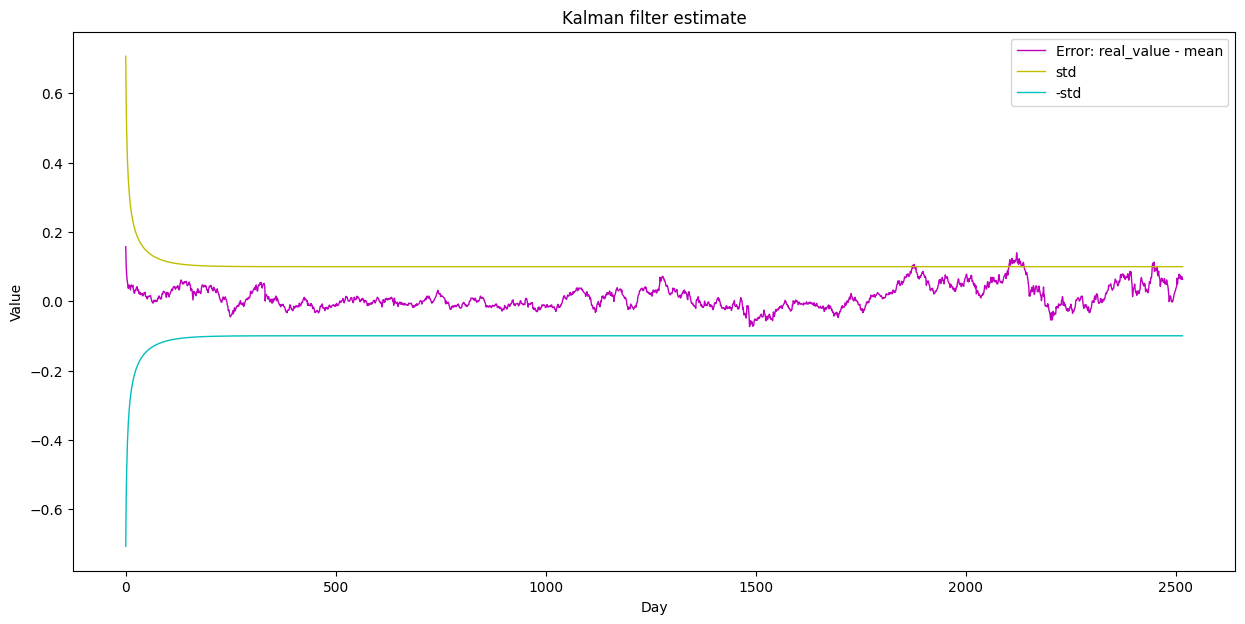

In [9]:
data2 = data.copy()
# The portfolio is long 1 unit of stock 1 and short 1 unit of stock2
data2['portfolio'] = (Stock1 - Stock2)
# Calculate the ratio of the closing prices for pairs trading
ratio = Stock1 / Stock2
data2['Ratio'] = ratio

# Initialize Kalman Filter
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=.0001
)

# Apply Kalman Filter to the ratio data
mean, cov = kf.filter(ratio)
mean, std = mean.squeeze(), np.std(cov.squeeze())

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(ratio - mean.reshape(-1, 1), 'm', lw=1)  # Plotting error: real_value - mean
plt.plot(np.sqrt(cov.squeeze()), 'y', lw=1)       # Plotting standard deviation
plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)      # Plotting negative standard deviation
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

# Calculate rolling mean and z_score
mean, cov = kf.filter(ratio)
data2['mean'] = mean.squeeze()
data2['cov'] = cov.squeeze()
data2['std'] = np.sqrt(data2['cov'])
data2 = data2.dropna()
data2['ma'] = data2['Ratio'].rolling(5).mean()
data2['z_score'] = (data2['ma'] - data2['mean']) / data2['std']

Residual analysis:
The series is stationary
(-5.284373521098099, 5.898869161149154e-06, 0, 2516, {'1%': -3.4329517425474014, '5%': -2.862689439250822, '10%': -2.5673818904827863}, -18790.013325676926)
p-value =  5.898869161149154e-06


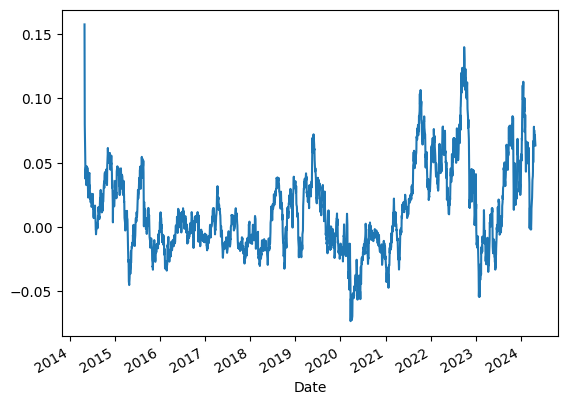

In [10]:
data2['residuals'] = data2['Ratio']- data2['mean']
# Apply an Augmented Dickey-Fuller (ADF) test to the residuals from your Kalman Filter analysis
print('Residual analysis:')
data2['residuals'].plot()
stationarity(data2['residuals'])

<Axes: xlabel='Date'>

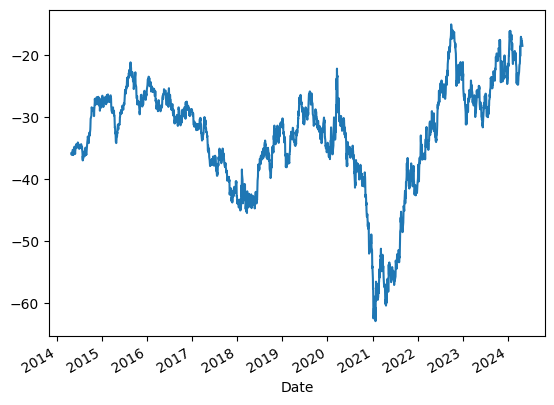

In [11]:
data2['portfolio'].plot()

### Strategy

In [12]:
data2['z_score'].describe()

count    2513.000000
mean        0.116228
std         0.319506
min        -0.663084
25%        -0.117073
50%         0.054513
75%         0.309999
max         1.230534
Name: z_score, dtype: float64

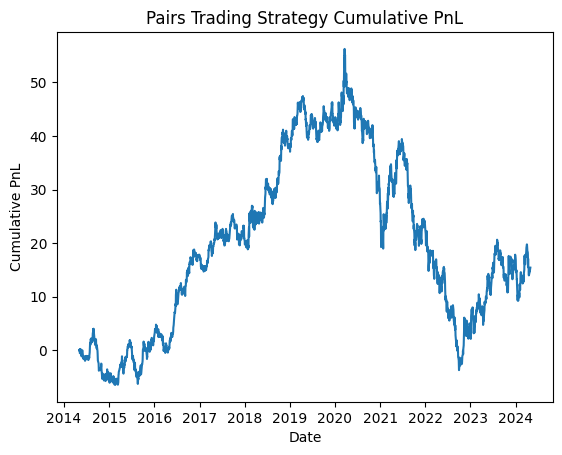

Part 2 back-testing result: {'Cumulative PnL': 15.429739570448685, 'Maximum Drawdown': -59.97213918378432, 'Sharpe Ratio': 0.13537129833955303, 'Profitability': 0.49920382165605093}


In [13]:
# Define strategy function by using Ratio (long 1 unit when z_score < benchmark and short 1 unit when z_score)
def sign(score, benchmark = 0.054513):
    return (score < benchmark) * 1 + (score > benchmark) * -1

# Define the back testing function
def back_testing(validation_data, r=0.05):
    validation_data['Sign'] = sign(validation_data['z_score'])
    validation_data.dropna(inplace=True)
    validation_data['PnL'] = 0.0
    number = 0
    account = 0
    old_price = 0
    for index, row in validation_data.iterrows():
        account *= np.exp(r * 1 / 252)
        pnl = number * (row['Adj Close'] - old_price) + (account - account * np.exp(- r * 1 / 252))
        validation_data.loc[index, 'PnL'] = pnl
        old_price = row['Adj Close']
        account -= row['Adj Close'] * (row['Sign'] - number)
        number = row['Sign']
    validation_data['Cum PnL'] = validation_data['PnL'].cumsum()
    # Calculate the maximum drawdown
    max_drawdown = (validation_data['Cum PnL'] - validation_data['Cum PnL'].cummax()).min()
    # Calculate the Sharpe Ratio
    sharpe_ratio = validation_data['PnL'].mean() * 252 / (validation_data['PnL'].std() * np.sqrt(252))
    # Calculate the profitability
    profitability = (validation_data['PnL'] > 0).sum() / ((validation_data['PnL'] > 0).sum() + (validation_data['PnL'] < 0).sum())
    # Plot the profit trend
    plt.plot(validation_data['Cum PnL'])
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.title('Pairs Trading Strategy Cumulative PnL')
    plt.show()

    return {
        'Cumulative PnL': validation_data['Cum PnL'].iloc[-1],
        'Maximum Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Profitability': profitability
    }
part2 = pd.DataFrame(data2[['portfolio', 'z_score']].values, index=data2.index, columns=["Adj Close",  "z_score"])
part2_result = back_testing(part2)
print('Part 2 back-testing result:', part2_result)

### Strategy 3

In [22]:
def fitKCA(t,z,q):
    '''
    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance

    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0]).days/t.shape[0]
    A=np.array([[1,h,.5*h**2],
    [0,1,h],
    [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)

    # Filtering
    state_means, state_covs = kf.filter(z)
    return state_means,state_covs

In [23]:
state_means,state_covs = fitKCA(data1['residuals'].index, data1['residuals'].values, 1)
kca = pd.DataFrame(state_means, index=data1.index, columns=['position', 'velocity', 'acceleration'])

<Axes: xlabel='Date'>

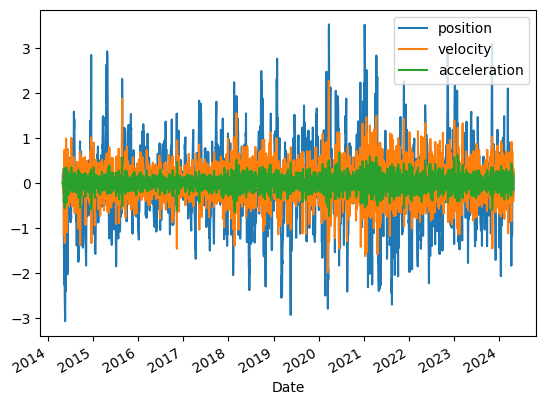

In [24]:
kca.plot()

<Axes: xlabel='Date'>

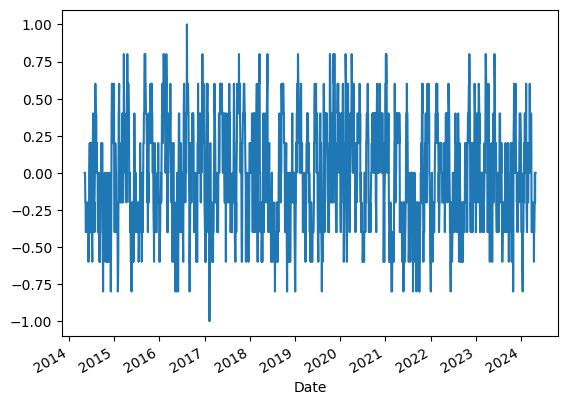

In [25]:
accgoesup = (((kca > 0.) * 1).sum(axis = 1) == 3) * 1
accgoesdown = (((kca < -0.) * 1).sum(axis = 1) == 3) * -1
momentum = (accgoesup + accgoesdown)
momentum.rolling(5).mean().plot()

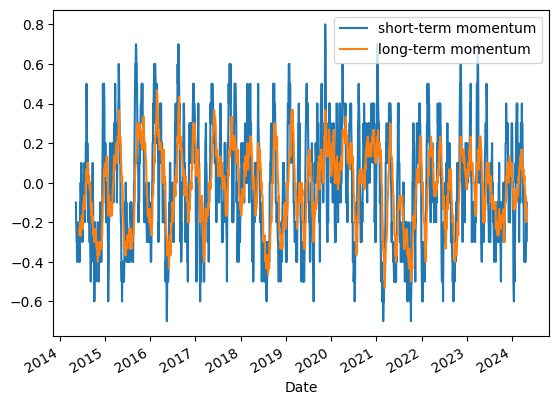

In [80]:
momentum.rolling(10).mean().plot()
momentum.rolling(30).mean().plot()
plt.legend(['short-term momentum', 'long-term momentum'])

In [81]:
signal = (momentum.rolling(10).mean() - momentum.rolling(30).mean() > 0) * -2 + 1

In [89]:
notional = 1000000
ticker1 = symbol_list[0]
ticker2 = symbol_list[1]

leg2_shares = notional / data['EWY'].values
# leg2_shares = 1

position = pd.DataFrame(index=data1.index, columns=[ticker1, ticker2])
position[ticker2] = leg2_shares
position[ticker1] = data1['beta'] * leg2_shares
position = position.mul(signal, axis=0)

In [90]:
prices = pd.concat([data1[[ticker1]], data1[[ticker2]]], axis=1)
price_diff = prices.diff(1)

sharpe ratio: 0.39
maximum drawdown: -0.72
profitability: 0.50


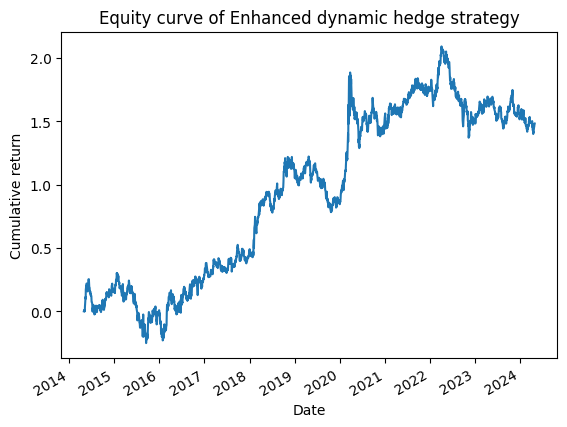

In [92]:
daily_return = (position.shift(1) * price_diff).sum(axis=1) / notional
daily_return.cumsum().plot(title='Equity curve of Enhanced dynamic hedge strategy')
plt.ylabel('Cumulative return')
sharpe_ratio = daily_return.mean() * 252 / (daily_return.std() * np.sqrt(252))
mdd = (daily_return.cumsum() - daily_return.cumsum().cummax()).min()
winning_rate = (daily_return.replace(0, np.nan).dropna() > 0).mean()

print(f"sharpe ratio: {sharpe_ratio:.2f}")
print(f"maximum drawdown: {mdd:.2f}")
print(f"profitability: {winning_rate:.2f}")